In [2]:
import numpy as np 
import pandas as pd  
import os
import torch
import torchvision
import torch.nn as nn 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torchvision.transforms.v2 as v2 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset 
from torchvision.datasets import ImageFolder
import torch.optim as optim 
from PIL import Image
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F



from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import Counter
from typing import Optional

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dir_path = 'Alzheimer_s Dataset'
test_ds = os.path.join(dir_path, 'test')
train_ds = os.path.join(dir_path, 'train')

In [5]:
train = ImageFolder(train_ds)
test = ImageFolder(test_ds)

class_map = {0:'Mild Demented', 1:'Moderate Demented', 2:'Non Demented', 3:'Very Mild Demented'}
class_dict = dict(Counter(train.targets))
class_dict

{0: 717, 1: 52, 2: 2560, 3: 1792}

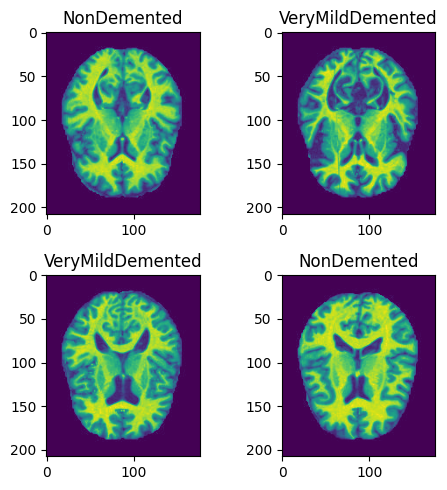

In [6]:
image_paths = []
for path in train.imgs:
    image_paths.append(path[0])
shuffled = image_paths.copy()    
random.shuffle(shuffled)
plt.figure(figsize=(5,5))
for i, path in enumerate(shuffled):
    if i>3: break
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    image_class = Path(path).parent.stem
    plt.title(image_class)
    plt.imshow(img)
plt.tight_layout()

In [7]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx][0])
        class_category = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, class_category

In [8]:
train_transform = v2.Compose([
                v2.Resize((128,128)),
                v2.Grayscale(num_output_channels=1),
                #v2.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
                #v2.ColorJitter(0.3,0.4,0.4,0.2),
                #v2.RandomCrop(size=(128,128)),
                v2.ToTensor(),
                #v2.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

test_transform = v2.Compose([
                v2.Resize((128,128)),
                v2.Grayscale(num_output_channels=1),
                v2.ToTensor(),
                #v2.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

/home/harikrishna/PythonProjects/alzhimers_prediction/alzh/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
train_data, train_label = train.imgs, train.targets
test_data, test_label = test.imgs, test.targets

#os.path.join(dir_path,train_data)
train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [10]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [11]:
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [12]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=4096, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))  
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))  
        
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = Net(num_classes=4).to(device)

print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,10,15], gamma=0.001)

In [14]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []
num_epochs=25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")

Epoch 1/25, Train Loss: 1.0547, Val Loss: 1.0437, Val Accuracy: 0.4721951219512195
Epoch 2/25, Train Loss: 1.0260, Val Loss: 0.9959, Val Accuracy: 0.4946341463414634
Epoch 3/25, Train Loss: 0.9442, Val Loss: 0.9058, Val Accuracy: 0.5541463414634147
Epoch 4/25, Train Loss: 0.9074, Val Loss: 0.8853, Val Accuracy: 0.5697560975609756
Epoch 5/25, Train Loss: 0.8805, Val Loss: 0.8686, Val Accuracy: 0.5678048780487804
Epoch 6/25, Train Loss: 0.8538, Val Loss: 0.8392, Val Accuracy: 0.5863414634146341
Epoch 7/25, Train Loss: 0.8260, Val Loss: 0.8102, Val Accuracy: 0.6019512195121951
Epoch 8/25, Train Loss: 0.7809, Val Loss: 0.7913, Val Accuracy: 0.6097560975609756
Epoch 9/25, Train Loss: 0.7252, Val Loss: 0.7837, Val Accuracy: 0.6175609756097561
Epoch 10/25, Train Loss: 0.6665, Val Loss: 0.7641, Val Accuracy: 0.6409756097560976
Epoch 11/25, Train Loss: 0.6015, Val Loss: 0.6600, Val Accuracy: 0.6897560975609756
Epoch 12/25, Train Loss: 0.5298, Val Loss: 0.6130, Val Accuracy: 0.7229268292682927
E

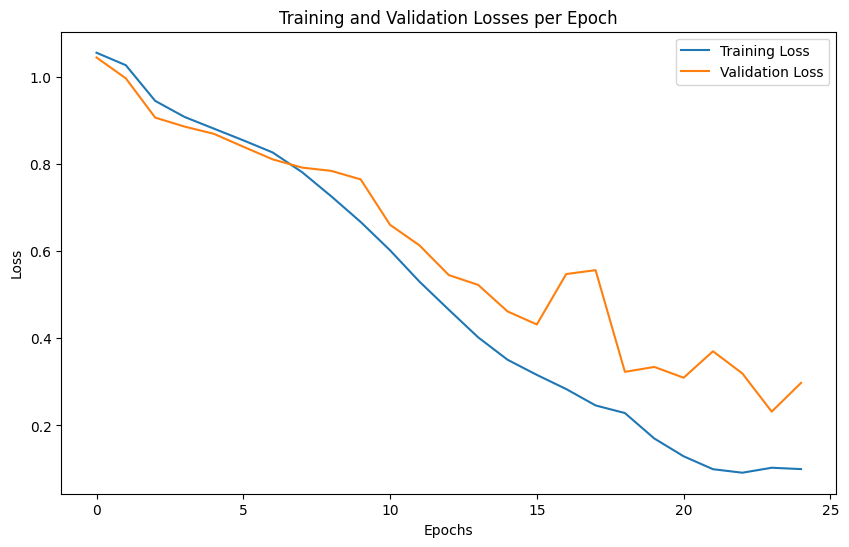

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
acc=[]
for i in val_accuracies:
    acc.append(i.cpu().data.numpy())

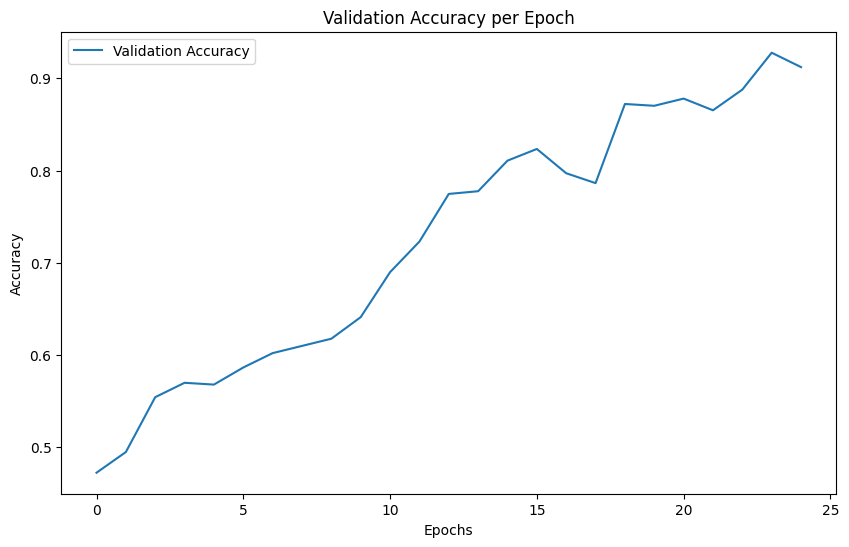

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(acc, label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
def pred_class(img):
    img_tens = test_transform(img)
    img_im = img_tens.unsqueeze(0).to(device)
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)

    index = out.data.cpu().numpy().argmax()
    return index

In [19]:
test_image_paths = []
for path in test.imgs:
    test_image_paths.append(path[0])
shuffled = test_image_paths.copy()    
random.shuffle(shuffled)

In [20]:
outcomes = os.listdir('Alzheimer_s Dataset/train')
classes = {k:v for k , v in enumerate(sorted(outcomes))}
classes

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

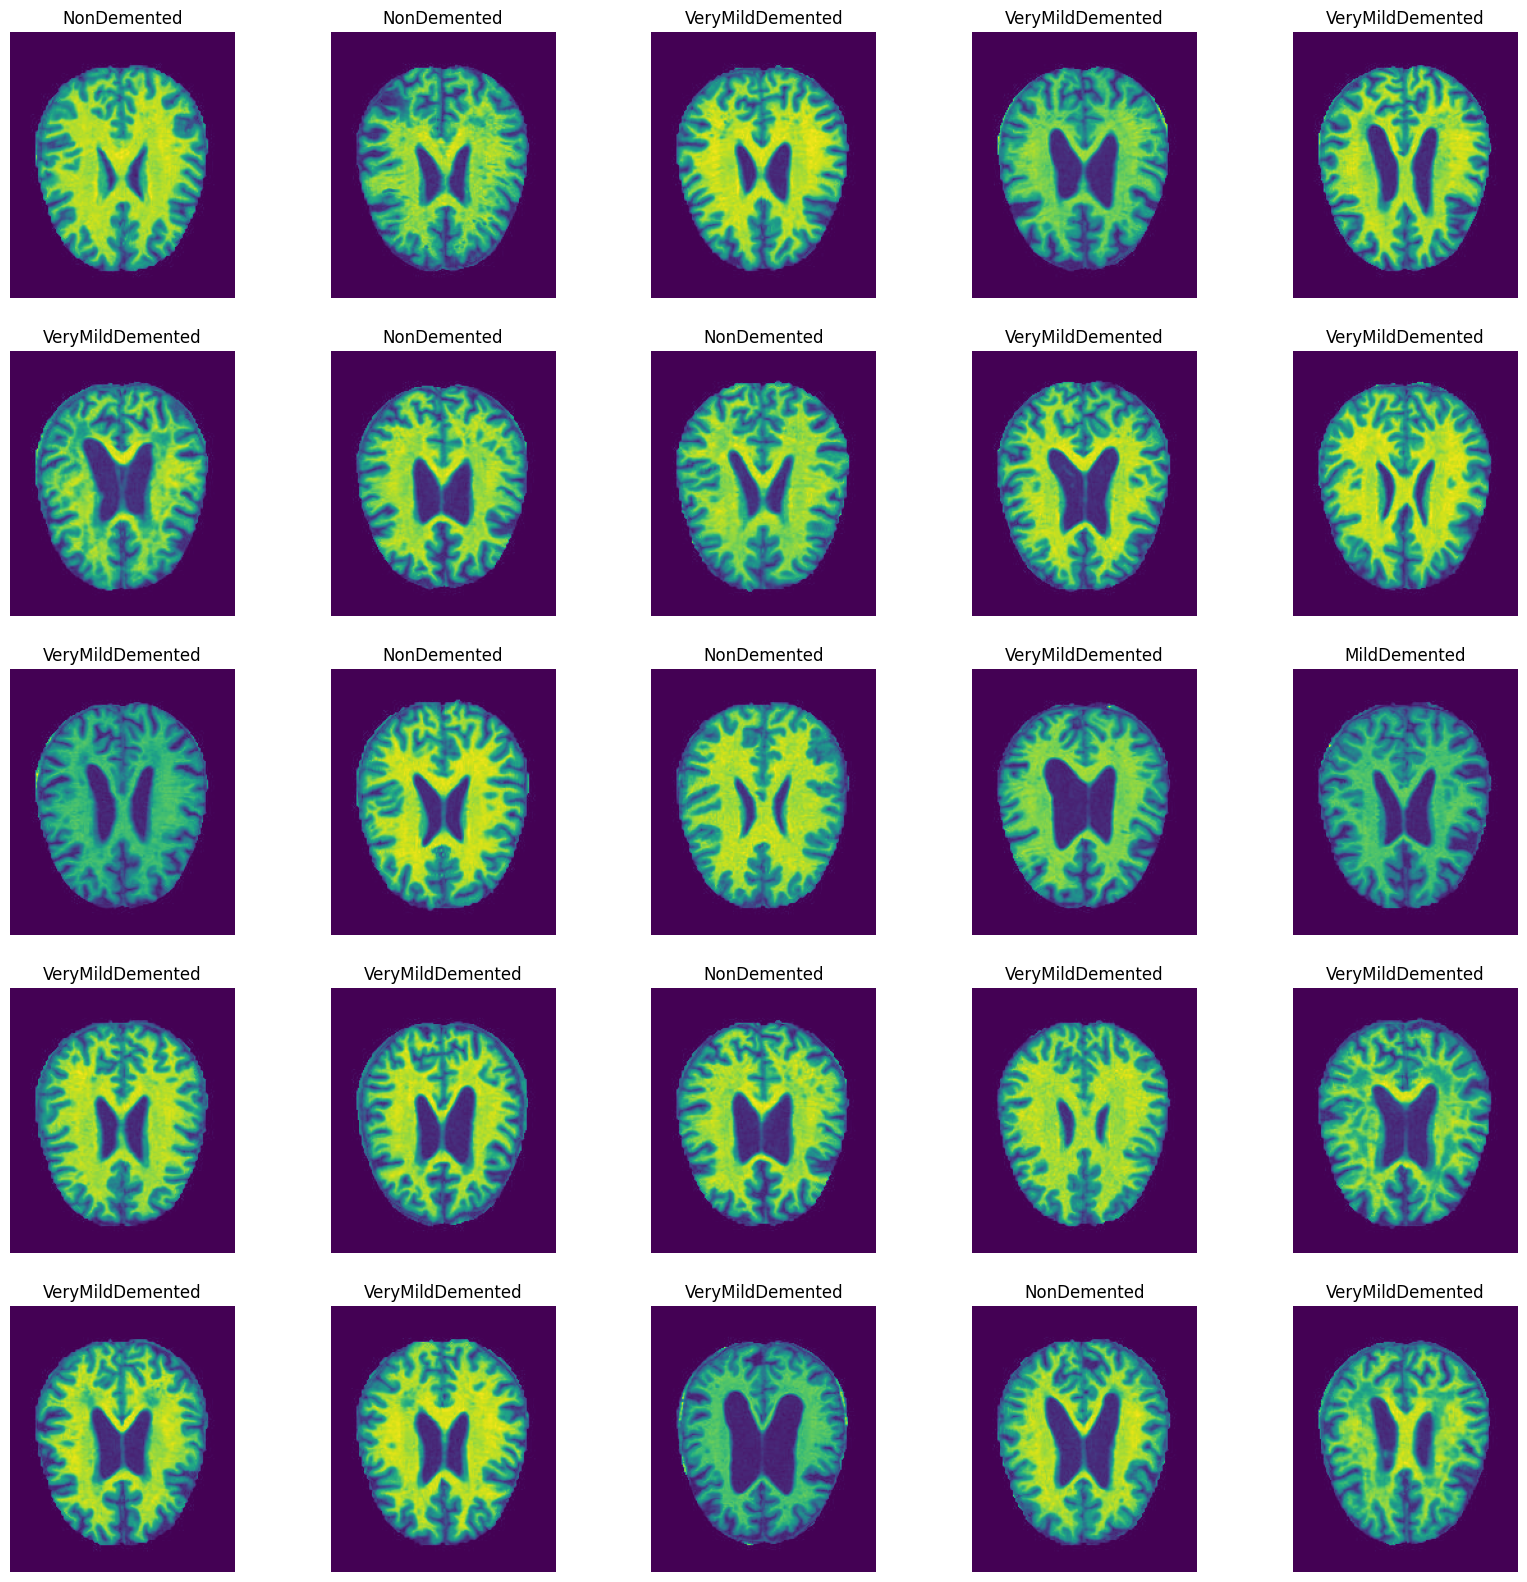

In [21]:
model.eval()

plt.figure(figsize=(20,20))
for i, images in enumerate(shuffled):
    # just want 25 images to print
    if i > 24:break
    img = Image.open(images)
    index = pred_class(img)
    plt.subplot(5,5,i+1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(img)

In [22]:
torch.save(model,'CNN_simple.pt')

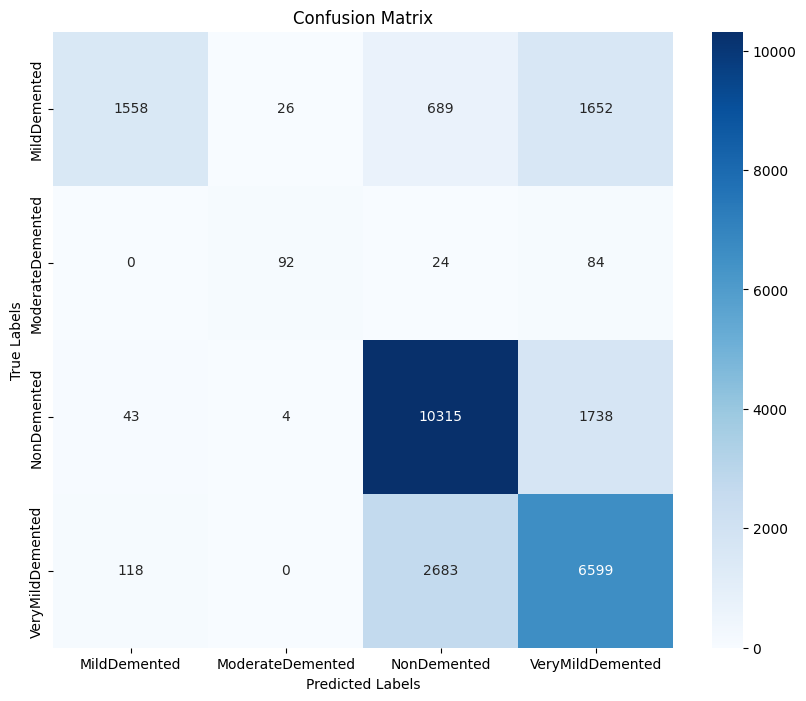

In [25]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], yticklabels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()